In [344]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import matplotlib.cm as cm
import scipy.misc
from astropy.io import fits
from astropy.visualization import ZScaleInterval,LinearStretch,ImageNormalize,SquaredStretch
from astropy.cosmology import WMAP9 as cosmo

In [345]:
get_ipython().magic('matplotlib inline')
pd.set_option('display.max_columns', None)
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100

In [346]:
#### calculate Lya Flux

def Fline(Bw, NB, Clambda_Bw=4035, Dlambda_Bw=1278, Clambda_NB=4030, Dlambda_NB=45, z=2.3):
    c=3e18# unit:(Angstrom/s)
    f_Bw = 10**(-0.4*(Bw+48.6))
    f_NB = 10**(-0.4*(NB+48.6))# f_v (erg s-1 cm-2 HZ-1)
    f_Bw = c / (Clambda_Bw ** 2) * f_Bw
    f_NB = c / (Clambda_NB ** 2) * f_NB# f_lambda (erg s-1 cm-2 A-1)
    f_cont = (f_Bw * Dlambda_Bw - f_NB * Dlambda_NB) / (Dlambda_Bw - Dlambda_NB)
    f_line = (f_NB - f_cont) * Dlambda_NB * (u.erg / (u.cm ** 2 * u.s))# fluxunit
    return f_line

In [347]:
#### calculate Lya Luminosity

def Luminosity(Bw, NB, Clambda_Bw=4035, Dlambda_Bw=1278, Clambda_NB=4030, Dlambda_NB=45, z=2.3):
    f_line = Fline(Bw, NB, Clambda_Bw, Dlambda_Bw, Clambda_NB, Dlambda_NB, z)
    L_line = (4* np.pi * cosmo.comoving_distance(z)**2 * f_line).to(u.erg/u.s)
    return L_line

In [348]:
def Scaleimgconverter(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=SquaredStretch())
    return norm

In [349]:
def CountPixel(img, x, y, boundary, lenth=30, greater='True'):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    if greater == 'True':
        return len(np.where(img > boundary)[0])
    else:
        return len(np.where(img < boundary)[0])

In [350]:
def FitsPresent(img, x, y, len=60):#, n):
    norm = Scaleimgconverter(img)
    plt.imshow(img, origin = 'lower', norm = norm, cmap=plt.cm.gray)
    # fig.colorbar(im)
    # plt.scatter(x, y, color='', marker='o', edgecolors='r', s=200)
    plt.xlim(x - len/2, x + len/2)
    plt.ylim(y - len/2, y + len/2)
    # plt.savefig('D:/lyadata/figure/4/' + n + '.png')

In [351]:
catfile_Bw = 'k4m_2239_1510_Bw.cat'
catfile_NB = 'k4m_2239_1510_NB_02.cat'
file_SDSS = 'k4m_2239_1510_Bw'
fitsfile_Bw = 'k4m_2239_1510_Bw_01.fits'
fitsfile_NB = 'k4m_2239_NB_1510_02_01.fits'

In [352]:
#### load data to pd.DateFrame

# clipped Bw/NB.fits
names1 = ['NUMBER', 'X_IMAGE', 'Y_IMAGE', 'ALPHA_J2000', 'DELTA_J2000', 'FLUX_APER', 'FLUXERR_APER', \
          'MAG_APER', 'CLASS_STAR']
Bw_rawdata = pd.DataFrame(np.genfromtxt(catfile_Bw, delimiter = None, names = names1))
NB_rawdata = pd.DataFrame(np.genfromtxt(catfile_NB, delimiter = None, names = names1))

names2 = ['_RAJ2000', '_DEJ2000', 'RA_ICRS', 'DE_ICRS', 'mode', 'q_mode', 'class','SDSS12', 'm_SDSS12', 'ObsDate', 'Q', 'umag',\
          'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag', 'zsp', 'zph', 'e_zph', '<zph>']
SDSS_rawdata = pd.DataFrame(np.genfromtxt(file_SDSS, delimiter = '\t', skip_header = 10,names = names2))

# color transfer from u&r to b band
SDSS_rawdata['bmag'] = SDSS_rawdata.umag - 0.8116 * (SDSS_rawdata.umag - SDSS_rawdata.gmag) + 0.1313
# SDSS_rawdata['bmag'] = SDSS_rawdata.gmag + 0.3130 * (SDSS_rawdata.gmag - SDSS_rawdata.rmag) + 0.2271

In [353]:
#### data screening

# pick points whose flux > 0
Bw_data = Bw_rawdata[Bw_rawdata.FLUX_APER > 0].reset_index(drop = 'True')
NB_data = NB_rawdata[NB_rawdata.FLUX_APER > 0].reset_index(drop = 'True')
Bw_data['mag'] = -2.5 * np.log10(Bw_data.FLUX_APER)
NB_data['mag'] = -2.5 * np.log10(NB_data.FLUX_APER)
# pick points whose class are star(class = 6)
SDSS_data = SDSS_rawdata[(SDSS_rawdata['class'] == 6) & (SDSS_rawdata.bmag > 17.5) & (SDSS_rawdata.bmag < 20.5)].reset_index(drop = 'True')

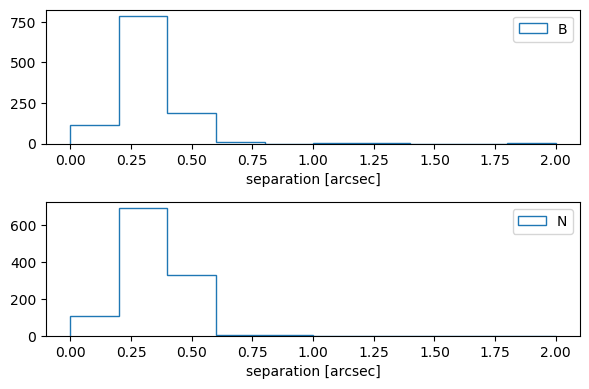

In [354]:
#### match source point between Bw/NB and SDSS

coo_Bw = SkyCoord(list(Bw_data.ALPHA_J2000) * u.degree, list(Bw_data.DELTA_J2000) * u.degree)
coo_NB = SkyCoord(list(NB_data.ALPHA_J2000) * u.degree, list(NB_data.DELTA_J2000) * u.degree)
coo_SDSS = SkyCoord(list(SDSS_data._RAJ2000) * u.degree, list(SDSS_data._DEJ2000) * u.degree)
idx_Bw, d2d_Bw, d3d_Bw = coo_SDSS.match_to_catalog_sky(coo_Bw)
idx_NB, d2d_NB, d3d_NB = coo_SDSS.match_to_catalog_sky(coo_NB)

# separation
plt.subplot(211)
plt.hist(d2d_Bw.arcsec, histtype='step', range=(0,2))
plt.xlabel('separation [arcsec]')
plt.legend('Bw')
plt.tight_layout()
plt.subplot(212)
plt.hist(d2d_NB.arcsec, histtype='step', range=(0,2))
plt.xlabel('separation [arcsec]')
plt.legend('NB')
plt.tight_layout()
plt.show()

In [355]:
##### select common points in Bw and NB

index_Bw = np.where((d2d_Bw < Angle('0d00m0.5s')))
index_NB = np.where((d2d_NB < Angle('0d00m0.5s')))
index = [index for index in index_Bw[0] if index in index_NB[0]]
idx_Bw = idx_Bw[index]
idx_NB = idx_NB[index]

D:\software\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
D:\software\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


standard deviation of zero points is: 0.11798257695368199
Zero point for Bw band is:  27.337846066522133
standard deviation of zero points is: 0.3579292106436475
Zero point for NB band is:  21.691020299571875


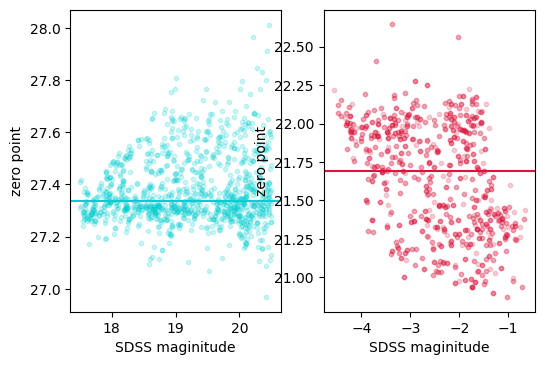

In [356]:
#### calibrate

Bw_mag = np.array([Bw_data['mag'][i] for i in idx_Bw])
NB_mag = np.array([NB_data['mag'][i] for i in idx_NB])
SDSS_mag = [SDSS_data.bmag[i] for i in index]
subt_SB = SDSS_mag - Bw_mag

zp_Bw = sigma_clip(subt_SB, sigma = 3, iters = 10)
zeropoint_Bw = np.median(zp_Bw)
subt_BN = Bw_mag + zeropoint_Bw - NB_mag
zp_NB = sigma_clip(subt_BN, sigma = 3, iters = 10)
zeropoint_NB = np.median(zp_NB)

plt.figure()
plt.subplot(121)
plt.scatter(SDSS_mag, subt_SB, s = np.pi * 1.75**2, c = '#00CED1', alpha=0.2)
plt.axhline(np.median(zp_Bw), c = '#00CED1')
plt.xlabel('SDSS maginitude'); plt.ylabel('zero point')
print('standard deviation of zero points is:', np.std(zp_Bw))
print("Zero point for Bw band is: ", zeropoint_Bw)
plt.subplot(122)
plt.scatter(NB_mag, subt_BN, s = np.pi * 1.75**2, c = '#DC143C', alpha=0.2)
plt.axhline(np.median(zp_NB), c = '#DC143C')
plt.xlabel('SDSS maginitude'); plt.ylabel('zero point')
print('standard deviation of zero points is:', np.std(zp_NB))
print("Zero point for NB band is: ", zeropoint_NB)
plt.show()

In [357]:
#### correct magnitude

Bw_data.mag = Bw_data.mag + zeropoint_Bw
NB_data.mag = NB_data.mag + zeropoint_NB

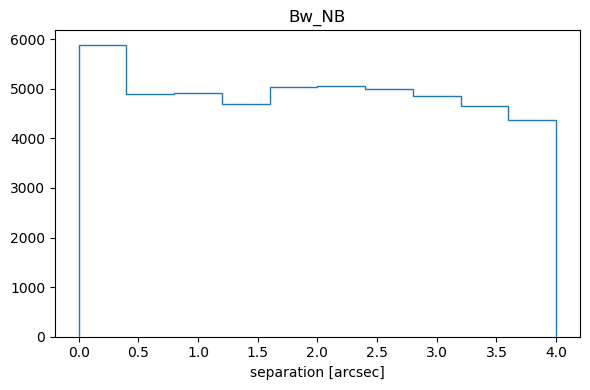

In [358]:
#### match Bw and NB

idx, d2d, d3d = coo_NB.match_to_catalog_sky(coo_Bw)
# seperation
plt.hist(d2d.arcsec, histtype='step', range=(0,4))
plt.xlabel('separation [arcsec]')
plt.title('Bw_NB')
plt.tight_layout()
plt.show()

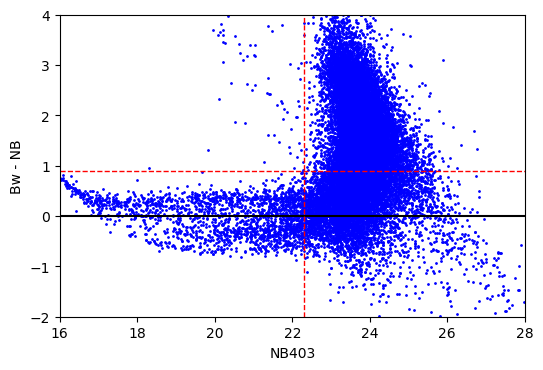

In [359]:
index_Bw_NB = np.where((d2d < Angle('0d00m02s')))
idx = idx[index_Bw_NB]
NB_data = NB_data.loc[index_Bw_NB].reset_index(drop = 'True')
Bw_data = Bw_data.loc[idx].reset_index(drop = 'True')

plt.scatter(NB_data.mag, Bw_data.mag - NB_data.mag, color = 'b', s = 1)
plt.axhline(0, color='k', linestyle='solid')
plt.axhline(0.9, color='r', linestyle='--', linewidth = 1)
plt.axvline(22.3, color='r', linestyle='--', linewidth = 1)
plt.axis([16, 28, -2, 4])
plt.xlabel('NB403')
plt.ylabel('Bw - NB')
plt.show()

In [360]:
Bw_select = Bw_data.copy()
Bw_select['NB_mag'] = NB_data.mag
Bw_select['Bw_minus_NB'] = Bw_data.mag - NB_data.mag
Bw_select['NB_X'] = NB_data.X_IMAGE
Bw_select['NB_Y'] = NB_data.Y_IMAGE
Bw_select['NB_RA'] = NB_data.ALPHA_J2000
Bw_select['NB_DE'] = NB_data.DELTA_J2000
Bw_select =  Bw_select[(Bw_select.Bw_minus_NB > 0.9) & (Bw_select.NB_mag < 22.3) & (Bw_select.NB_mag > 16)].reset_index(drop = 'True')

In [361]:
hdu1 = fits.open(fitsfile_Bw)[0]
wcs1 = WCS(hdu1.header)#; hdu1.close()
hdu2 = fits.open(fitsfile_NB)[0]
wcs2 = WCS(hdu2.header)#; hdu2.close()

img = hdu2.data - 10**((zeropoint_NB - zeropoint_Bw)/2.5) * hdu1.data

# get area of area per pixel
ra, dec = wcs1.all_pix2world([0, wcs1.array_shape[0]], [0, wcs1.array_shape[1]], 1)
deg_to_pix = (dec[1] - dec [0]) * (ra[0] - ra[1])/wcs1.array_shape[0]/wcs1.array_shape[1] * 3600**2
# calculate candidate size
arcsecarea = np.array([CountPixel(img, Bw_select['NB_X'][i], Bw_select['NB_Y'][i], 0.07, 30) * deg_to_pix for i in range(len(Bw_select['NB_Y']))])
arcsecarea1 = np.array([CountPixel(img, Bw_select['NB_X'][i], Bw_select['NB_Y'][i], -0.10, 30, greater='False') * deg_to_pix for i in range(len(Bw_select['NB_Y']))])
Bw_select['arcsecarea'] = arcsecarea
Bw_select['lyaLuminosity'] = Luminosity(np.array(Bw_select.mag), np.array(Bw_select.NB_mag))
Bw_select['surfacebrightness'] = Fline(np.array(Bw_select.mag), np.array(Bw_select.NB_mag))/Bw_select.arcsecarea

D:\software\Anaconda\lib\site-packages\astropy\units\quantity.py:466: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


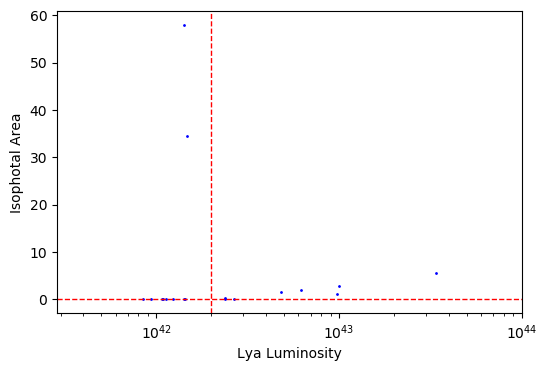

In [362]:
Bw_select = Bw_select.loc[np.where(arcsecarea1 < 10)]

plt.semilogx()
plt.scatter(Bw_select.lyaLuminosity,Bw_select.arcsecarea, color = 'b', s=1)
plt.axhline(0, color='r', linestyle='--', linewidth = 1)
plt.axvline(2e42, color='r', linestyle='--', linewidth = 1)
plt.xlabel('Lya Luminosity')
plt.ylabel('Isophotal Area')
plt.show()

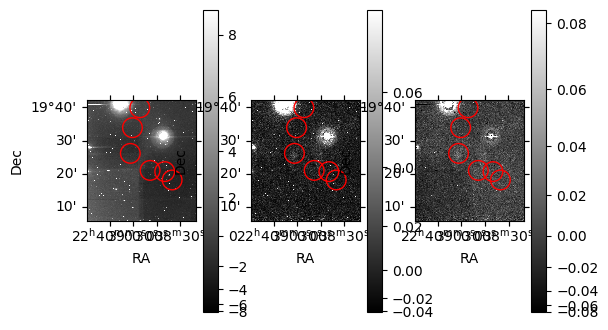

In [363]:
Bw_select = Bw_select[(Bw_select.lyaLuminosity > 2e42) & (Bw_select.arcsecarea > 0) & (Bw_select.NB_Y <8300)]

fig = plt.figure()
ax1 = fig.add_subplot(131, projection=wcs1)
norm1 = Scaleimgconverter(hdu1.data)
plt.imshow(hdu1.data, origin='lower', norm = norm1, cmap=plt.cm.gray)
plt.colorbar()
plt.scatter(Bw_select.NB_X, Bw_select.NB_Y, transform=ax1.get_transform(wcs1), color='', marker='o', edgecolors='r', s=200)
plt.xlabel('RA'); plt.ylabel('Dec')
ax2 = fig.add_subplot(132, projection=wcs2)
norm2 = Scaleimgconverter(hdu2.data)
plt.imshow(hdu2.data, origin='lower', norm = norm2, cmap=plt.cm.gray)
plt.colorbar()
plt.scatter(Bw_select.NB_X, Bw_select.NB_Y, transform=ax2.get_transform(wcs2), color='', marker='o', edgecolors='r', s=200)
plt.xlabel('RA'); plt.ylabel('Dec')
ax3 = fig.add_subplot(133, projection=wcs2)
norm = Scaleimgconverter(img)
plt.imshow(img, origin='lower', norm = norm, cmap=plt.cm.gray)
plt.colorbar()
plt.scatter(Bw_select.NB_X, Bw_select.NB_Y, transform=ax3.get_transform(wcs2), color='', marker='o', edgecolors='r', s=200)
plt.xlabel('RA'); plt.ylabel('Dec')
plt.show()

In [364]:
print(Bw_select[['ALPHA_J2000', 'DELTA_J2000', 'mag', 'NB_mag','arcsecarea', 'lyaLuminosity','surfacebrightness']])

    ALPHA_J2000  DELTA_J2000        mag     NB_mag  arcsecarea  lyaLuminosity  \
3    339.668354    19.302566  22.388701  20.516058    1.987128   6.236405e+42   
5    339.707624    19.344607  19.265893  18.311540    5.630197   3.384690e+43   
6    339.785463    19.350646  22.647959  20.790384    1.523465   4.829359e+42   
12   339.890242    19.435815  22.425456  20.100810    1.126039   9.814897e+42   
13   339.879304    19.564918  21.134298  19.823175    2.848217   1.007682e+43   
15   339.840112    19.664847  25.535362  21.738443    0.264950   2.385977e+42   

    surfacebrightness  
3        8.047002e-16  
5        1.541420e-15  
6        8.127982e-16  
12       2.234899e-15  
13       9.071436e-16  
15       2.309017e-15  


In [365]:
# for i in range(len(Bw_select)):
#     plt.subplot(len(Bw_select), 3, 3*i+1); FitsPresent(hdu1.data, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
#     plt.subplot(len(Bw_select), 3, 3*i+2); FitsPresent(hdu2.data, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
#     plt.subplot(len(Bw_select), 3, 3*i+3); FitsPresent(img, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
# plt.show()

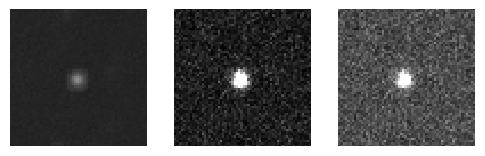

In [366]:
i = 0
plt.subplot(1, 3, 1); FitsPresent(hdu1.data, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
plt.subplot(1, 3, 2); FitsPresent(hdu2.data, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
plt.subplot(1, 3, 3); FitsPresent(img, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
plt.show()

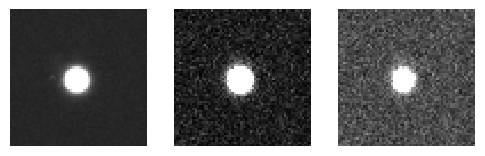

In [367]:
i = 1
plt.subplot(1, 3, 1); FitsPresent(hdu1.data, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
plt.subplot(1, 3, 2); FitsPresent(hdu2.data, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
plt.subplot(1, 3, 3); FitsPresent(img, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
plt.show()

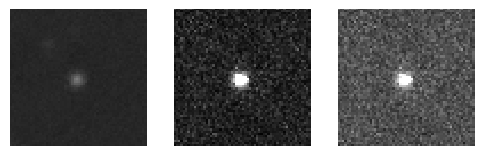

In [368]:
i = 2
plt.subplot(1, 3, 1); FitsPresent(hdu1.data, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
plt.subplot(1, 3, 2); FitsPresent(hdu2.data, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
plt.subplot(1, 3, 3); FitsPresent(img, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
plt.show()

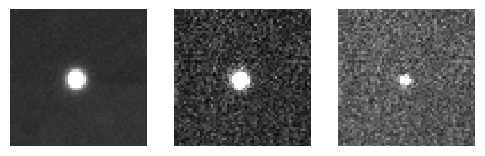

In [369]:
i = 3
plt.subplot(1, 3, 1); FitsPresent(hdu1.data, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
plt.subplot(1, 3, 2); FitsPresent(hdu2.data, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
plt.subplot(1, 3, 3); FitsPresent(img, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
plt.show()

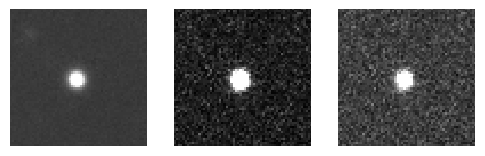

In [370]:
i = 4
plt.subplot(1, 3, 1); FitsPresent(hdu1.data, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
plt.subplot(1, 3, 2); FitsPresent(hdu2.data, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
plt.subplot(1, 3, 3); FitsPresent(img, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
plt.show()

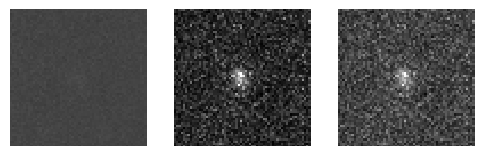

In [371]:
i = 5
plt.subplot(1, 3, 1); FitsPresent(hdu1.data, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
plt.subplot(1, 3, 2); FitsPresent(hdu2.data, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
plt.subplot(1, 3, 3); FitsPresent(img, Bw_select.iloc[i]['NB_X'], Bw_select.iloc[i]['NB_Y']);plt.axis('off')
plt.show()